In [1]:
#%% Paquetes a utilizar
import random
import collections
import math
import os
import zipfile
import time
import re 

import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
# !pip install Unidecode
from unidecode import unidecode
from nltk.stem import SnowballStemmer

import numpy as np
import tensorflow as tf

from matplotlib import pylab
%matplotlib inline

from six.moves import range
from six.moves.urllib.request import urlretrieve

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
#!git clone https://github.com/milocortes/GastoSocial.git

In [2]:
#%% Carga de catálogos
catalogo = pd.read_csv('/home/milo/Documentos/Python/TextMining/catalogo.csv', encoding='ISO-8859-1').\
           fillna('   ')
# Cargamos la base a calificar
#%% Cargar base a calificar
base = pd.read_csv('/home/milo/Documentos/Python/TextMining/CalifConeval.csv',
                     encoding='ISO-8859-1',
                     index_col='RMP').fillna("")

In [3]:
# Generamos una función que aplicará las transformaciones necesarias al texto

def nltk_fun(column):
  # Cambiamos mayúsculas por minúsculas
  
  column=column.apply(lambda x: " ".join(x.lower() for x in x.split()))
  # Removemos Stopwords
  import nltk
  from nltk.corpus import stopwords
  
  stop = stopwords.words('spanish')
  
  column=column.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  # Removemos puntuación
  import re
  
  column=column.str.replace(r'[^\w\s]', '')
  # Removemos acentos
  import unidecode
  
  column=column.apply(lambda x: "".join(unidecode.unidecode(x)))
  # Tokenizing Text
  column=column.apply(lambda x: nltk.word_tokenize(x))
  # Realizamos el stemming
  stemmer = SnowballStemmer("spanish")
  column=column.apply(lambda x: [stemmer.stem(y) for y in x])
  
  # Cambiamos las listas a String
  column=column.apply(lambda x: " ".join(str(y) for y in x))

  # Eliminamos los espacios innecesarios
  column=column.apply(lambda x: re.sub(' +',' ',x))
  
  return(column)

In [4]:
### Aplicamos la función anterior a cada una de las columnas en el catálogo y en las descripciones
import nltk
nltk.download('stopwords')
nltk.download('punkt')

base_lista=['DESC_FIN','DESC_PROPOSITO','DESC_PP','DESC_AI']
catalogo_lista=['Categoria','Categoria_Auxiliar_1','Categoria_Auxiliar_2']


for x in base_lista:
    base[x]=nltk_fun(base[x])
    
for x in catalogo_lista:
    catalogo[x]=nltk_fun(catalogo[x])

In [5]:
catalogo.head()

,id,Objetivo,id_derecho,Derecho,Categoria,Categoria_Auxiliar_1,Categoria_Auxiliar_2
0,1.1,1,1,Alimentación,acuicol,comerci,
1,1.1,1,1,Alimentación,acuicol,produccion,
2,1.1,1,1,Alimentación,acuicol,product,
3,1.1,1,1,Alimentación,acuicol,productor,
4,1.1,1,1,Alimentación,agricol,comerci,


In [6]:
base.head()

,Ciclo,DESC_FIN,DESC_PROPOSITO,DESC_PP,DESC_AI
RMP,,,,,
1K025,2008,,,proyect inmuebl oficin administr,llev cab proces legisl
1K027,2008,,,manten infraestructur,llev cab proces legisl
1R001,2008,,,activ deriv trabaj legisl,llev cab proces legisl
1R002,2008,,,present inform result,fiscalizacion cuent haciend public federal
1R301,2008,,,activ deriv trabaj legisl ampliacion determin ...,llev cab proces legisl


In [7]:
### Cambiamos algunas palabras a  cada una de las columnas en el catálogo y en las descripciones

lista_uno=["\\bagu\\b","\\bcomun\\b","\\bcontingent\\b","\\bguard\\b","\\bpol\\b","\\bsostenibil\\b","\\bzon\\b",
           "\\bmicr\\b","\\bpequeñ\\b","\\bmedian\\b","\\bcooper\\b","\\basistent\\b",
           "\\bcalid\\b","\\bcomun\\b","\\bpermanent\\b","\\bproduct\\b","\\bsegur\\b","\\bfinanci\\b","\\bfinanci\\b"]
lista_dos=['agua','comunidad','contingencia','guarderia','polo','sostenib','zona','micro','peque','mediana',
           'cooperativa','asistencia','calidad','comunic','perman','productividad','seguridad','financiamiento','financiamiento']


import time
start = time.time()

for y in range(0,18):
    for x in catalogo_lista:
        catalogo[x]=catalogo[x].apply(lambda z: re.sub(lista_uno[y],lista_dos[y],z))
        # Cambiamos las listas a String
        catalogo[x]=catalogo[x].apply(lambda z: "".join(str(y) for y in z))


for y in range(0,18):
    for x in base_lista:
        base[x]=base[x].apply(lambda z: re.sub(lista_uno[y],lista_dos[y],z))
        # Cambiamos las listas a String
        base[x]=base[x].apply(lambda z: "".join(str(y) for y in z))

end = time.time()
print(end - start)


6.850265741348267


In [8]:
base.columns

Index(['Ciclo', 'DESC_FIN', 'DESC_PROPOSITO', 'DESC_PP', 'DESC_AI'], dtype='object')

In [9]:
### Hacemos un corpus con la columna de DESC_PP

desc_pp_corpus=base['DESC_PP'].str.cat(sep=' ')

In [10]:
def text_processing(ft8_text):
    """Replacing punctuation marks with tokens"""
    ft8_text = ft8_text.lower()
    ft8_text = ft8_text.replace('.', ' <period> ')
    ft8_text = ft8_text.replace(',', ' <comma> ')
    ft8_text = ft8_text.replace('"', ' <quotation> ')
    ft8_text = ft8_text.replace(';', ' <semicolon> ')
    ft8_text = ft8_text.replace('!', ' <exclamation> ')
    ft8_text = ft8_text.replace('?', ' <question> ')
    ft8_text = ft8_text.replace('(', ' <paren_l> ')
    ft8_text = ft8_text.replace(')', ' <paren_r> ')
    ft8_text = ft8_text.replace('--', ' <hyphen> ')
    ft8_text = ft8_text.replace(':', ' <colon> ')
    ft8_text_tokens = ft8_text.split()
    
    return ft8_text_tokens

In [11]:
ft_tokens = text_processing(desc_pp_corpus)
"""Shortlisting words with frequency more than 7"""
word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > 7 ]

List the top words present in the dataset on the basis of their
frequency, as follows:

In [12]:
print(shortlisted_words[:15])

['proyect', 'inmuebl', 'oficin', 'administr', 'manten', 'infraestructur', 'activ', 'deriv', 'trabaj', 'legisl', 'present', 'inform', 'result', 'activ', 'deriv']


Check the stats of the total words present in the dataset.

In [13]:
print("Total number of shortlisted words : ",len(shortlisted_words))
print("Unique number of shortlisted words : ",len(set(shortlisted_words)))

Total number of shortlisted words :  53878
Unique number of shortlisted words :  1077


To process the unique words present in the corpus, we have made a
set of the words, followed by their frequency in the training dataset. The
following function creates a dictionary and converts words to integers
and, conversely, integers to words. The most frequent word is assigned the
least value, 0, and in similar fashion, numbers are assigned to other words.
Conversion of words to integers has been stored in a separate list.

In [14]:
def dict_creation(shortlisted_words):
    """The function creates a dictionary of the words present in dataset along with their frequency order"""
    counts = collections.Counter(shortlisted_words)
    vocabulary = sorted(counts, key=counts.get, reverse=True)
    program_dictionary_ = {ii: word for ii, word in enumerate(vocabulary)}
    dictionary_ = {word: ii for ii, word in program_dictionary_.items()}
    return dictionary_, program_dictionary_


In [15]:
dictionary_, program_dictionary_ = dict_creation(shortlisted_words)
words_cnt = [dictionary_[word] for word in shortlisted_words]

The variables created up to this point are common and could be used
in the implementation of the either of the word2vec models. The next
subsections include the implementation of both architectures.

## Skip-Gram Code

A subsampling approach has been coupled in the skip-gram model to deal
with the stopwords in the text. All the words with higher frequency and
without any significant context around the center words are removed by
putting a threshold on their frequency. This results in faster training and
better word vector representations.

In [16]:

"""Creating the threshold and performing the subsampling"""
thresh = 0.00005
word_counts = collections.Counter(words_cnt)
total_count = len(words_cnt)
freqs = {word: count / total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(thresh/freqs[word]) for word in word_counts}
train_words = [word for word in words_cnt if p_drop[word] < random.random()]

As the skip-gram model takes the center word and predicts words
surrounding it, the skipG_target_set_generation() function creates the
input for the skip-gram model in the desired format:As the skip-gram model takes the center word and predicts words
surrounding it, the skipG_target_set_generation() function creates the
input for the skip-gram model in the desired format:

In [17]:
def skipG_target_set_generation(batch_, batch_index, word_window): 
    """The function combines the words of given word_window size next to the index, for the SkipGram model"""
    random_num = np.random.randint(1, word_window+1)
    words_start = batch_index - random_num if (batch_index - random_num) > 0 else 0
    words_stop = batch_index + random_num
    window_target = set(batch_[words_start:batch_index] + batch_[batch_index+1:words_stop+1])
    return list(window_target)

The skipG_batch_creation() function makes use of the skipG_
target_set_generation() function and creates a combined format of the
center word and the words surrounding it on either side as target text and
returns the batch output, as follows:

In [18]:
def skipG_batch_creation(short_words, batch_length, word_window):
    """The function internally makes use of the skipG_target_set_generation() function and combines each of the label 
    words in the shortlisted_words with the words of word_window size around"""
    batch_cnt = len(short_words)//batch_length
    short_words = short_words[:batch_cnt*batch_length]  
    
    for word_index in range(0, len(short_words), batch_length):
        input_words, label_words = [], []
        word_batch = short_words[word_index:word_index+batch_length]
        for index_ in range(len(word_batch)):
            batch_input = word_batch[index_]
            batch_label = skipG_target_set_generation(word_batch, index_, word_window)
            # Appending the label and inputs to the initial list. Replicating input to the size of labels in the window 
            label_words.extend(batch_label)
            input_words.extend([batch_input]*len(batch_label))
        yield input_words, label_words

The following code registers a TensorFlow graph for use of the
skip-gram implementation, declaring the variable’s inputs and labels
placeholders, which will be used to assign one-hot-encoded vectors for
input words and batches of varying size, as per the combination of the
center and surrounding words:

In [19]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


tf_graph = tf.Graph()
with tf_graph.as_default():
    input_ = tf.placeholder(tf.int32, [None], name='input_')
    label_ = tf.placeholder(tf.int32, [None, None], name='label_')

with tf_graph.as_default():
    word_embed = tf.Variable(tf.random_uniform((len(program_dictionary_), 300), -1, 1))
    embedding = tf.nn.embedding_lookup(word_embed, input_)

Instructions for updating:
non-resource variables are not supported in the long term


The code following declares variables for the embedding matrix, which
has a dimension equal to the size of the vocabulary and the dimension of
the word embedding vector:
    
The tf.train.AdamOptimizer uses Diederik P. Kingma and Jimmy
Ba’s Adam algorithm (http://arxiv.org/pdf/1412.6980v8.pdf) to
control the learning rate. For further information, refer additionally to the
following paper by Bengio: http://arxiv.org/pdf/1206.5533.pdf.

In [20]:
"""The code includes the following  :
 # Initializing weights and bias to be used in the softmax layer
 # Loss function calculation using the Negative Sampling
 # Usage of Adam Optimizer
 # Negative sampling on 100 words, to be included in the loss function
 # 300 is the word embedding vector size
"""
vocabulary_size = len(program_dictionary_)

with tf_graph.as_default():
    sf_weights = tf.Variable(tf.truncated_normal((vocabulary_size, 300), stddev=0.1) )
    sf_bias = tf.Variable(tf.zeros(vocabulary_size) )

    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights, biases=sf_bias, 
                                         labels=label_, inputs=embedding, 
                                         num_sampled=100, num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    optim = tf.train.AdamOptimizer().minimize(cost_fn)

To ensure that the word vector representation is holding the semantic
similarity among words, a validation set is generated in the following
section of code. This will select a combination of common and uncommon
words across the corpus and return the words closest to them on the basis
of the cosine similarity between the word vectors.

In [21]:
"""The below code performs the following operations :
 # Performing validation here by making use of a random selection of 16 words from the dictionary of desired size
 # Selecting 8 words randomly from range of 1000    
 # Using the cosine distance to calculate the similarity between the words 
"""
with tf_graph.as_default():
    validation_cnt = 8
    validation_dict = 50
    
    validation_words = np.array(random.sample(range(validation_dict), validation_cnt//2))
    validation_words = np.append(validation_words, random.sample(range(1000,1000+validation_dict), validation_cnt//2))
    validation_data = tf.constant(validation_words, dtype=tf.int32)

    normalization_embed = word_embed / (tf.sqrt(tf.reduce_sum(tf.square(word_embed), 1, keepdims=True)))
    validation_embed = tf.nn.embedding_lookup(normalization_embed, validation_data)
    word_similarity = tf.matmul(validation_embed, tf.transpose(normalization_embed))
    

Create a folder model_checkpoint in the current working directory to
store the model checkpoints.

In [22]:
"""Creating the model checkpoint directory"""
!mkdir model_checkpoint


epochs = 60          # Increase it as per computation resources. It has been kept low here for users to replicate the process, increase to 100 or more
batch_length = 100
word_window = 10

with tf_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=tf_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = skipG_batch_creation(train_words, batch_length, word_window)
        start = time.time()
        for x, y in batches:
            train_loss, _ = sess.run([cost_fn, optim], 
                                     feed_dict={input_: x, label_: np.array(y)[:, None]})
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs), ", Iteration: {}".format(iteration),
                      ", Avg. Training loss: {:.4f}".format(loss/100),", Processing : {:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 2000 == 0:
                similarity_ = word_similarity.eval()
                for i in range(validation_cnt):
                    validated_words = program_dictionary_[validation_words[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-similarity_[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % validated_words
                    for k in range(top_k):
                        close_word = program_dictionary_[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "model_checkpoint/skipGram_gasto_social.ckpt")
    embed_mat = sess.run(normalization_embed)

mkdir: no se puede crear el directorio «model_checkpoint»: El archivo ya existe
Epoch 1/60 , Iteration: 100 , Avg. Training loss: 4.9920 , Processing : 0.0100 sec/batch
Epoch 2/60 , Iteration: 200 , Avg. Training loss: 4.7678 , Processing : 0.0049 sec/batch
Epoch 3/60 , Iteration: 300 , Avg. Training loss: 4.5781 , Processing : 0.0052 sec/batch
Epoch 4/60 , Iteration: 400 , Avg. Training loss: 4.3928 , Processing : 0.0047 sec/batch
Epoch 5/60 , Iteration: 500 , Avg. Training loss: 4.2317 , Processing : 0.0045 sec/batch
Epoch 6/60 , Iteration: 600 , Avg. Training loss: 4.0702 , Processing : 0.0046 sec/batch
Epoch 7/60 , Iteration: 700 , Avg. Training loss: 3.9166 , Processing : 0.0046 sec/batch
Epoch 8/60 , Iteration: 800 , Avg. Training loss: 3.7755 , Processing : 0.0046 sec/batch
Epoch 9/60 , Iteration: 900 , Avg. Training loss: 3.6559 , Processing : 0.0054 sec/batch
Epoch 10/60 , Iteration: 1000 , Avg. Training loss: 3.5519 , Processing : 0.0048 sec/batch
Epoch 11/60 , Iteration: 110

A similar output will be printed for all other iterations, and the trained
network will have been restored for further use.

In [23]:
"""The Saver class adds ops to save and restore variables to and from checkpoints."""
with tf_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=tf_graph) as sess:
    """Restoring the trained network"""
    saver.restore(sess, tf.train.latest_checkpoint('model_checkpoint'))
    embed_mat = sess.run(word_embed)

INFO:tensorflow:Restoring parameters from model_checkpoint/skipGram_gasto_social.ckpt


We have used the t-distributed stochastic neighbor embedding (t-SNE)
for the purpose of visualization (https://lvdmaaten.github.io/tsne/).
The high-dimensional, 300 vector representation of 250 random words has
been used across a two-dimensional vector space. t-SNE ensures that the
initial structure of the vector is reserved in the new dimension, even after
conversion.

Using the vector representation of 250 words to show their distribution across the new vector space

In [24]:
word_graph = 250
tsne = TSNE()
word_embedding_tsne = tsne.fit_transform(embed_mat[:word_graph, :])

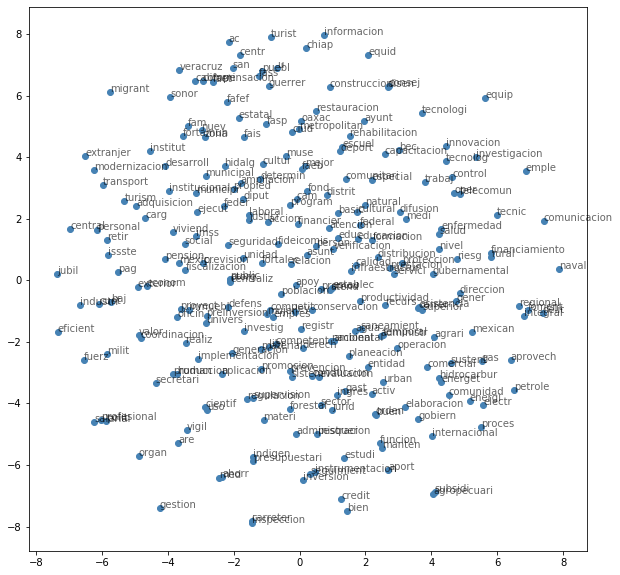

In [25]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(figsize=(10, 10))
for idx in range(word_graph):
    plt.scatter(*word_embedding_tsne[idx, :], color='steelblue')
    plt.annotate(program_dictionary_[idx], (word_embedding_tsne[idx, 0], word_embedding_tsne[idx, 1]), alpha=0.6)

Text(0.5, 1.0, 'PCA')

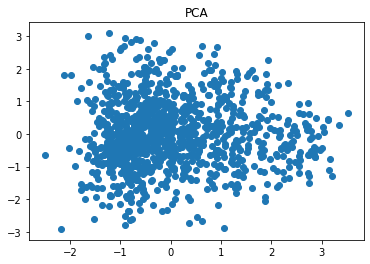

In [48]:
## Veremos la representación en 2 dimensiones con un PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(embed_mat)

fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1])
ax.set_title('PCA')

In [162]:
## Usaremos un Autocodificador para explorar la existencia de grupos
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(embed_mat)
dim = X.shape[-1]

Se define el autocodificador con un espacio latente de 2 dimensiones, se entrena y se proyectan los vectores del conjunto de datos pasandolos por el codificador:

In [167]:
cod = Sequential([Dense(70, activation='sigmoid', input_shape=(dim,)),
                  Dense(60,activation='linear'),
                  Dense(40,activation='sigmoid'),
                  Dense(30,activation='linear'),
                  Dense(20,activation='linear'),                  
                  Dense(2, activation='linear')])
dec = Sequential([Dense(10, activation='sigmoid', input_shape=(2,)),
                  Dense(dim, activation='linear')])
ac = Model(cod.inputs, dec(cod.outputs))

ac.compile(optimizer='adam', loss='mse')
ac.fit(X, X, epochs=100)
X_ac = cod.predict(X)

Train on 1077 samples
Epoch 1/100
1077/1077 [==============================] - 2s 1ms/sample - loss: 1.0104
Epoch 2/100
1077/1077 [==============================] - 0s 99us/sample - loss: 1.0009
Epoch 3/100
1077/1077 [==============================] - 0s 105us/sample - loss: 0.9967
Epoch 4/100
1077/1077 [==============================] - 0s 103us/sample - loss: 0.9942
Epoch 5/100
1077/1077 [==============================] - 0s 106us/sample - loss: 0.9931
Epoch 6/100
1077/1077 [==============================] - 0s 108us/sample - loss: 0.9922
Epoch 7/100
1077/1077 [==============================] - 0s 112us/sample - loss: 0.9915
Epoch 8/100
1077/1077 [==============================] - 0s 97us/sample - loss: 0.9907
Epoch 9/100
1077/1077 [==============================] - 0s 109us/sample - loss: 0.9900
Epoch 10/100
1077/1077 [==============================] - 0s 99us/sample - loss: 0.9893
Epoch 11/100
1077/1077 [==============================] - 0s 104us/sample - loss: 0.9886
Epoch 12/100


Text(0.5, 1.0, 'Autocodificador')

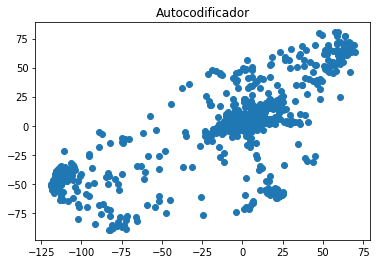

In [168]:
## Veremos la representación en 2 dimensiones del Autocodificador

fig, ax = plt.subplots()
ax.scatter(X_ac[:,0], X_ac[:,1])
ax.set_title('Autocodificador')    

In [211]:
# Guardamos el la reducción de dimensiones en un data frame
data_skip_gram={'x1':list(X_ac[:,0]),'x2':list(X_ac[:,1])}

pd_data_skip_gram=pd.DataFrame(data_skip_gram)

pd_programDic={'word':program_dictionary_}
pd_programDic=pd.DataFrame(pd_programDic)

pd.concat([pd_programDic,pd_data_skip_gram],axis=1).to_csv('/home/milo/Documentos/Python/TextMining/skipGram.csv')
               

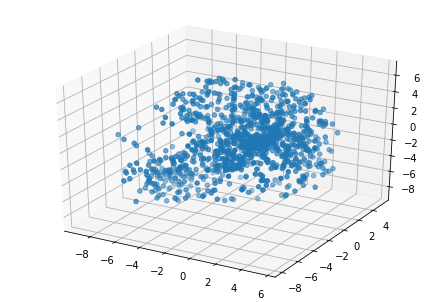

In [71]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D


fig = pyplot.figure()
ax = Axes3D(fig)

x_vals=X_ac[:,0]
y_vals=X_ac[:,1]
z_vals=X_ac[:,2]

ax.scatter(x_vals, y_vals, z_vals)
pyplot.show()

## CBOW Code


The CBOW model considers the surrounding words and predicts the
center word. Therefore, the batch and label generation have been achieved
using the cbow_batch_creation() function, which assigns the target
word in the label_ variable and the surrounding words in the context in
the batch variable, when the desired word_window size is passed to the
function.

In [102]:

data_index = 0

def cbow_batch_creation(batch_length, word_window):
    """The function creates a batch with the list of the label words and list of their corresponding words in the context of
    the label word."""
    global data_index
    """Pulling out the centered label word, and its next word_window count of surrounding words
    word_window : window of words on either side of the center word
    relevant_words : length of the total words to be picked in a single batch, 
            including the center word and the word_window words on both sides
    Format :  [ word_window ... target ... word_window ] """
    relevant_words = 2 * word_window + 1 

    batch = np.ndarray(shape=(batch_length,relevant_words-1), dtype=np.int32)
    label_ = np.ndarray(shape=(batch_length, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=relevant_words)   # Queue to add/pop

    #Selecting the words of length 'relevant_words' from the starting index 
    for _ in range(relevant_words):
        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)

    for i in range(batch_length):
        target = word_window  # Center word as the label
        target_to_avoid = [ word_window ] # Excluding the label, and selecting only the surrounding words

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(relevant_words):
            if j==relevant_words//2:
                continue
            batch[i,col_idx] = buffer[j] # Iterating till the middle element for window_size length
            col_idx += 1
        label_[i, 0] = buffer[target]

        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)

    assert batch.shape[0]==batch_length and batch.shape[1]== relevant_words-1
    return batch, label_

Ensuring the cbow_batch_creation() function is working in
accordance with the CBOW model input, a test sample of the first batch of
label and words of window length 1 and 2 around it has been taken and the
results are printed.

In [103]:
for num_skips, word_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, label_ = cbow_batch_creation(batch_length=8, word_window=word_window)
    print('\nwith num_skips = %d and word_window = %d:' % (num_skips, word_window))
    
    print('    batch:', [[program_dictionary_[bii] for bii in bi] for bi in batch])
    print('    label_:', [program_dictionary_[li] for li in label_.reshape(8)])


with num_skips = 2 and word_window = 1:
    batch: [['proyect', 'oficin'], ['inmuebl', 'administr'], ['oficin', 'manten'], ['administr', 'infraestructur'], ['manten', 'activ'], ['infraestructur', 'deriv'], ['activ', 'trabaj'], ['deriv', 'legisl']]
    label_: ['inmuebl', 'oficin', 'administr', 'manten', 'infraestructur', 'activ', 'deriv', 'trabaj']

with num_skips = 4 and word_window = 2:
    batch: [['proyect', 'inmuebl', 'administr', 'manten'], ['inmuebl', 'oficin', 'manten', 'infraestructur'], ['oficin', 'administr', 'infraestructur', 'activ'], ['administr', 'manten', 'activ', 'deriv'], ['manten', 'infraestructur', 'deriv', 'trabaj'], ['infraestructur', 'activ', 'trabaj', 'legisl'], ['activ', 'deriv', 'legisl', 'present'], ['deriv', 'trabaj', 'present', 'inform']]
    label_: ['oficin', 'administr', 'manten', 'infraestructur', 'activ', 'deriv', 'trabaj', 'legisl']


The following code declares the variables being used in the CBOW
model configuration. The word-embedding vector has been assigned a
size of 128, and on either side of the target word, 1 word has been taken
into account for the prediction, as follows:

In [104]:
num_steps = 100001
"""Initialzing :
   # 128 is the length of the batch considered for CBOW
   # 128 is the word embedding vector size
   # Considering 1 word on both sides of the center label words
   # Consider the center label word 2 times to create the batches
"""
batch_length = 128
embedding_size = 128
skip_window = 1
num_skips = 2

To register a TensorFlow graph for use of the CBOW implementation
and to calculate the cosine similarity between the vectors produced, use
the following code:

In [105]:
"""The below code performs the following operations :
 # Performing validation here by making use of a random selection of 16 words from the dictionary of desired size
 # Selecting 8 words randomly from range of 1000    
 # Using the cosine distance to calculate the similarity between the words 
"""

tf_cbow_graph = tf.Graph()

with tf_cbow_graph.as_default():
    validation_cnt = 8
    validation_dict = 50
    
    validation_words = np.array(random.sample(range(validation_dict), validation_cnt//2))
    validation_words = np.append(validation_words,random.sample(range(1000,1000+validation_dict), validation_cnt//2))

    train_dataset = tf.placeholder(tf.int32, shape=[batch_length,2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_length, 1])
    validation_data = tf.constant(validation_words, dtype=tf.int32)

In [106]:
"""
Embeddings for all the words present in the vocabulary
"""
with tf_cbow_graph.as_default() :
    vocabulary_size = len(program_dictionary_)
    
    word_embed = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Averaging embeddings accross the full context into a single embedding layer
    context_embeddings = []
    for i in range(2*skip_window):
        context_embeddings.append(tf.nn.embedding_lookup(word_embed, train_dataset[:,i]))

    embedding =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)

The following section of code computes the softmax loss using the
negative sampling of 64 words and further optimizes the weights, biases,
and word embeddings produced across the model training. The AdaGrad
optimizer(www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) has
been used for this purpose.

In [107]:
"""The code includes the following  :
 # Initializing weights and bias to be used in the softmax layer
 # Loss function calculation using the Negative Sampling
 # Usage of AdaGrad Optimizer
 # Negative sampling on 64 words, to be included in the loss function
"""
with tf_cbow_graph.as_default() :
    sf_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size)))
    sf_bias = tf.Variable(tf.zeros([vocabulary_size]))

    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights, biases=sf_bias, inputs=embedding,
                           labels=train_labels, num_sampled=64, num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    """Using AdaGrad as optimizer"""
    optim = tf.train.AdagradOptimizer(1.0).minimize(cost_fn)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Further, a cosine similarity is computed to ensure the closeness of the
semantically similar words.

In [108]:

""" 
Using the cosine distance to calculate the similarity between the batches and embeddings of other words 
"""
with tf_cbow_graph.as_default() :
    
    normalization_embed = word_embed / tf.sqrt(tf.reduce_sum(tf.square(word_embed), 1, keepdims=True))
    validation_embed = tf.nn.embedding_lookup(normalization_embed, validation_data)
    word_similarity = tf.matmul(validation_embed, tf.transpose(normalization_embed))

In [109]:
with tf.Session(graph=tf_cbow_graph) as sess:
    sess.run(tf.global_variables_initializer())

    avg_loss = 0
    for step in range(num_steps):
        batch_words, batch_label_ = cbow_batch_creation(batch_length, skip_window)
        _, l = sess.run([optim, loss_fn], feed_dict={train_dataset : batch_words, train_labels : batch_label_ })
        avg_loss += l
        if step % 2000 == 0 :
            if step > 0 :
                avg_loss = avg_loss / 2000
            print('Average loss at step %d: %f' % (step, np.mean(avg_loss) )) 
            avg_loss = 0
        
        if step % 10000 == 0:
            sim = word_similarity.eval()
            for i in range(validation_cnt):
                valid_word = program_dictionary_[validation_words[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = program_dictionary_[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalization_embed.eval()

Average loss at step 0: 4.915748
Nearest to determin: jubil, reproduct, regulatori, informacion, famili, analiz, desplaz, sindicat,
Nearest to prevencion: vulner, nayarit, trav, artes, fon, profesional, organ, comunal,
Nearest to diput: herramient, ciudadani, acces, estudi, part, republ, registr, bucal,
Nearest to electr: convencion, ramon, analiz, udis, jurid, negoci, centraliz, adiccion,
Nearest to licu: militar, gobiern, anterior, ac, dignificacion, luz, taller, bec,
Nearest to solidari: bilateral, acueduct, formacion, libert, mexiquens, program, inmuebl, asesor,
Nearest to facultad: ayunt, yucat, monitore, chaping, epidemiolog, edicion, econom, autonom,
Nearest to cruel: vihs, defens, administr, demand, dem, issste, vigil, morel,
Average loss at step 2000: 1.263452
Average loss at step 4000: 0.571557
Average loss at step 6000: 0.461633
Average loss at step 8000: 0.403255
Average loss at step 10000: 0.374681
Nearest to determin: negoci, reproduct, religi, jubil, regulatori, usuari, 

Average loss at step 92000: 0.270900
Average loss at step 94000: 0.262997
Average loss at step 96000: 0.265331
Average loss at step 98000: 0.264580
Average loss at step 100000: 0.265632
Nearest to determin: religi, negoci, vincul, reproduct, civic, invalidez, remodelacion, demograf,
Nearest to prevencion: testamentari, compensacion, fon, estos, victim, servidor, seguridad, vulner,
Nearest to diput: unid, guadalaj, posgr, territori, recopilacion, cultur, unidad, patrimoni,
Nearest to electr: extern, petroquim, pequen, bien, hidrocarbur, verd, cutzamal, contribuyent,
Nearest to licu: militar, ac, devolucion, gobiern, gas, taller, faeb, guerrer,
Nearest to solidari: bilateral, avecind, subsidi, vulner, congel, potosi, emision, salarial,
Nearest to facultad: ayunt, chaping, autonom, energi, edicion, mecan, cumpl, adecuacion,
Nearest to cruel: muert, issste, fallec, rehabilitacion, vihs, pesaj, dem, auditori,


Using t-SNE for visualization purposes, the high-dimensional, 128,
vector representation of 250 random words has been used to show the
result across a two-dimensional space.

In [110]:
num_points = 250

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
embeddings_2d = tsne.fit_transform(final_embeddings[1:num_points+1, :])

The cbow_plot() function plots the dimensionally reduced vectors.

In [111]:
def cbow_plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(12,12))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

Figure 2-14 also illustrates that the words with semantic similarity
are placed closer to one another in their two-dimensional space
representation. For example, words like right, left, and end have been
placed next to one another and far from such words as one, two, three, etc.
Among all the words presented here, we can observe, at the bottom
left of the graph, that those related to a single alphabet are placed closer
to one another. This helps us to understand how the model works and
allocates the single characters with no significant meaning with similar
word embeddings. The absence of such words as a and i in this cluster
indicates that the word embeddings for the two alphabets related to these
two words are not similar to other individual alphabets, as these hold
actual meaning in the English language and are used more often than
other alphabets, in which they are merely signs of a typo in the training
dataset. A further training of the model with higher iterations can attempt
to bring the vectors of these alphabets closer or further from the actual
meaningful words of the language.

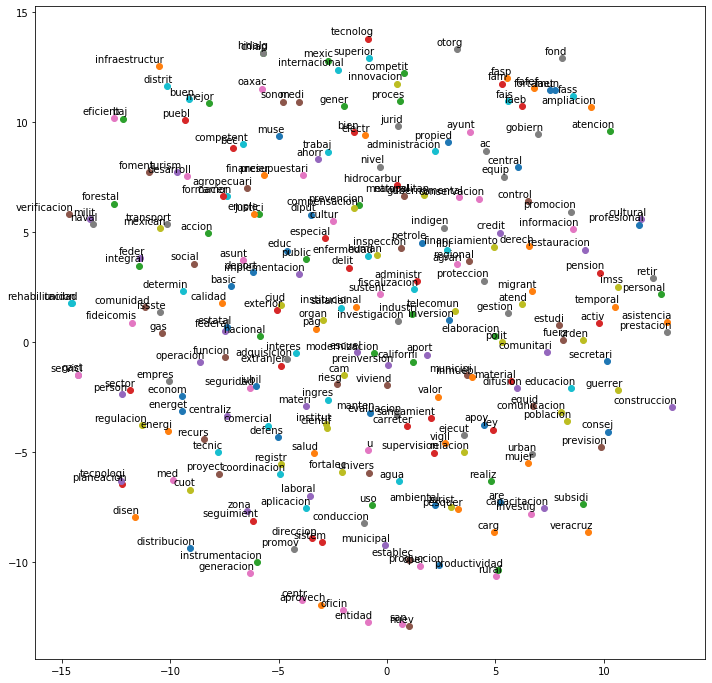

In [112]:
words = [program_dictionary_[i] for i in range(1, num_points+1)]
cbow_plot(embeddings_2d, words)

Text(0.5, 1.0, 'PCA')

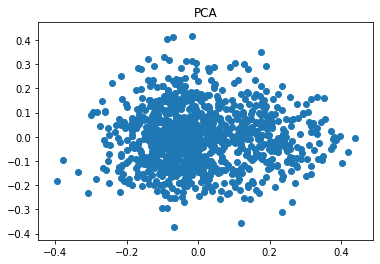

In [117]:
## Veremos la representación en 2 dimensiones con un PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_cbow = pca.fit_transform(final_embeddings)

fig, ax = plt.subplots()
ax.scatter(X_pca_cbow[:,0], X_pca_cbow[:,1])
ax.set_title('PCA')

In [120]:
## Usaremos un Autocodificador para explorar la existencia de grupos
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_cbow = sc.fit_transform(final_embeddings)
dim_cbow = X_cbow.shape[-1]

Se define el autocodificador con un espacio latente de 2 dimensiones, se entrena y se proyectan los vectores del conjunto de datos pasandolos por el codificador:

In [159]:
cod = Sequential([Dense(70, activation='sigmoid', input_shape=(dim_cbow,)),
                  Dense(60,activation='linear'),
                  Dense(40,activation='sigmoid'),
                  Dense(30,activation='linear'),
                  Dense(20,activation='linear'),                
                  Dense(2, activation='linear')])
dec = Sequential([Dense(10, activation='sigmoid', input_shape=(2,)),
                  Dense(dim_cbow, activation='linear')])
ac = Model(cod.inputs, dec(cod.outputs))

ac.compile(optimizer='adam', loss='mse')
ac.fit(X_cbow, X_cbow, epochs=100)
X_ac_cbow = cod.predict(X_cbow)

Train on 1077 samples
Epoch 1/100
1077/1077 [==============================] - 1s 1ms/sample - loss: 1.0109
Epoch 2/100
1077/1077 [==============================] - 0s 99us/sample - loss: 1.0016
Epoch 3/100
1077/1077 [==============================] - 0s 92us/sample - loss: 0.9940
Epoch 4/100
1077/1077 [==============================] - 0s 100us/sample - loss: 0.9886
Epoch 5/100
1077/1077 [==============================] - 0s 97us/sample - loss: 0.9861
Epoch 6/100
1077/1077 [==============================] - 0s 98us/sample - loss: 0.9848
Epoch 7/100
1077/1077 [==============================] - 0s 94us/sample - loss: 0.9839
Epoch 8/100
1077/1077 [==============================] - 0s 100us/sample - loss: 0.9832
Epoch 9/100
1077/1077 [==============================] - 0s 90us/sample - loss: 0.9825
Epoch 10/100
1077/1077 [==============================] - 0s 104us/sample - loss: 0.9817
Epoch 11/100
1077/1077 [==============================] - 0s 90us/sample - loss: 0.9812
Epoch 12/100
1077

Text(0.5, 1.0, 'Autocodificador')

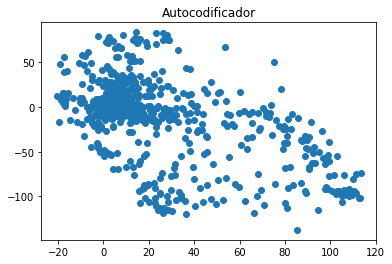

In [160]:
## Veremos la representación en 2 dimensiones del Autocodificador                  Dense(10,activation='linear'), 

fig, ax = plt.subplots()
ax.scatter(X_ac_cbow[:,0], X_ac_cbow[:,1])
ax.set_title('Autocodificador')    

In [213]:
# Guardamos el la reducción de dimensiones en un data frame
data_cbow={'x1':list(X_ac_cbow[:,0]),'x2':list(X_ac_cbow[:,1])}

pd_data_cbow=pd.DataFrame(data_cbow)

pd_programDic={'word':program_dictionary_}
pd_programDic=pd.DataFrame(pd_programDic)

pd.concat([pd_programDic,pd_data_cbow],axis=1).to_csv('/home/milo/Documentos/Python/TextMining/CBOW.csv')